In [1]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.8 MB/s eta 0:00:0

In [2]:
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

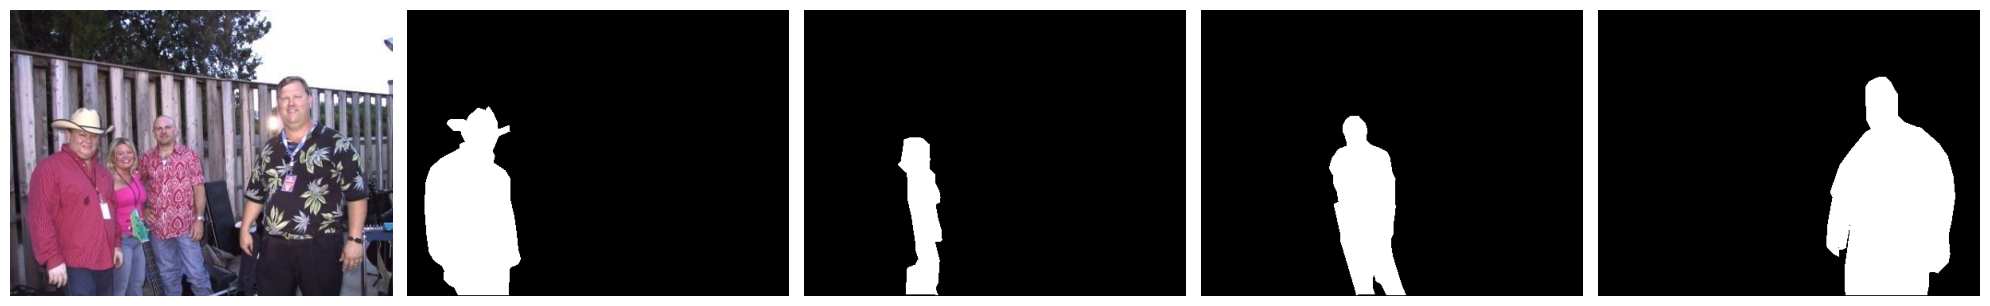

In [4]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [16]:
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:28<00:00, 173.14it/s]


In [17]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [18]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [19]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

══════════════════════════════════════════════════════════════════

tensor([[[0.6627, 0.6588, 0.6471,  ..., 0.0431, 0.0667, 0.1176],
         [0.6627, 0.6588, 0.6471,  ..., 0.0431, 0.0667, 0.1098],
         [0.6627, 0.6588, 0.6471,  ..., 0.0431, 0.0392, 0.0588],
         ...,
         [0.6314, 0.6275, 0.6235,  ..., 0.8196, 0.8235, 0.8235],
         [0.6549, 0.6510, 0.6510,  ..., 0.8157, 0.8235, 0.8275],
         [0.6667, 0.6627, 0.6588,  ..., 0.8039, 0.8039, 0.8039]],

        [[0.8275, 0.8314, 0.8353,  ..., 0.0667, 0.0902, 0.1412],
         [0.8275, 0.8314, 0.8353,  ..., 0.0667, 0.0902, 0.1333],
         [0.8275, 0.8314, 0.8353,  ..., 0.0627, 0.0588, 0.0784],
         ...,
         [0.6078, 0.6039, 0.6000,  ..., 0.7843, 0.7882, 0.7882],
         [0.6314, 0.6275, 0.6275,  ..., 0.7843, 0.7922, 0.7961],
         [0.6431, 0.6392, 0.6353,  ..., 0.7725, 0.7725, 0.7725]],

        [[0.9765, 0.9765, 0.9922,  ..., 0.0275, 0.0510, 0.1020],
         [0.9765, 0.9765, 0.9922,  ..., 0.0275, 0.0510, 0.0941],
         [0.9765, 0.9765, 0.9922,  ..., 0.0353, 0.0314, 0.0510],
         ...,
         [0.6157, 0.6118, 0.6078,  ..., 0.7882, 0.7922, 0.7922],
         [0.6392, 0.6353, 0.6353,  ..., 0.7765, 0.7843, 0.7882],
         [0.6510, 0.6471, 0.6431,  ..., 0.7608, 0.7647, 0.7647]]])

══════════════════════════════════════════════════════════════════

dict of 6 items

tensor([[292., 269., 299., 280.],
        [277., 270., 287., 280.],
        [148., 266., 154., 281.]])

tensor([1, 1, 1])

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

tensor([0])

tensor([ 77., 100.,  90.])

... ... 1 more item(s)

══════════════════════════════════════════════════════════════════

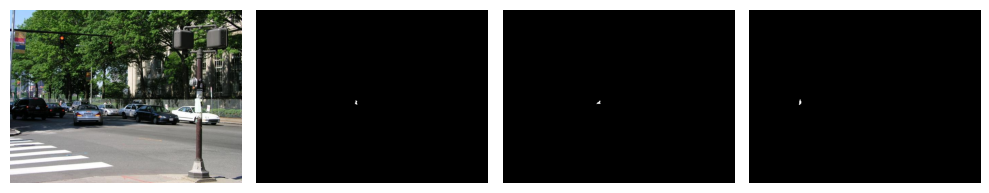

In [20]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [21]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer, num_classes)
    return model

In [22]:
model = get_model_instance_segmentation(2).to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 39.4MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [23]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [24]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [25]:
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/475]  eta: 1:07:23  lr: 0.000016  loss: 2.4573 (2.4573)  loss_classifier: 0.5659 (0.5659)  loss_box_reg: 0.1640 (0.1640)  loss_mask: 1.6369 (1.6369)  loss_objectness: 0.0592 (0.0592)  loss_rpn_box_reg: 0.0313 (0.0313)  time: 8.5128  data: 0.0605  max mem: 2328
Epoch: [0]  [ 10/475]  eta: 0:10:52  lr: 0.000121  loss: 2.7376 (2.6438)  loss_classifier: 0.5848 (0.5900)  loss_box_reg: 0.3662 (0.3452)  loss_mask: 1.7754 (1.6318)  loss_objectness: 0.0372 (0.0467)  loss_rpn_box_reg: 0.0200 (0.0302)  time: 1.4039  data: 0.0910  max mem: 3168
Epoch: [0]  [ 20/475]  eta: 0:07:50  lr: 0.000226  loss: 1.9275 (2.0539)  loss_classifier: 0.4664 (0.4657)  loss_box_reg: 0.3433 (0.3440)  loss_mask: 0.7366 (1.1744)  loss_objectness: 0.0258 (0.0425)  loss_rpn_box_reg: 0.0165 (0.0273)  time: 0.6611  data: 0.0647  max mem: 3716
Epoch: [0]  [ 30/475]  eta: 0:06:42  lr: 0.000332  loss: 1.3124 (1.7646)  loss_classifier: 0.3109 (0.4041)  loss_box_reg: 0.3551 (0.3604)  loss_mask: 0.5665 (0.9391) 

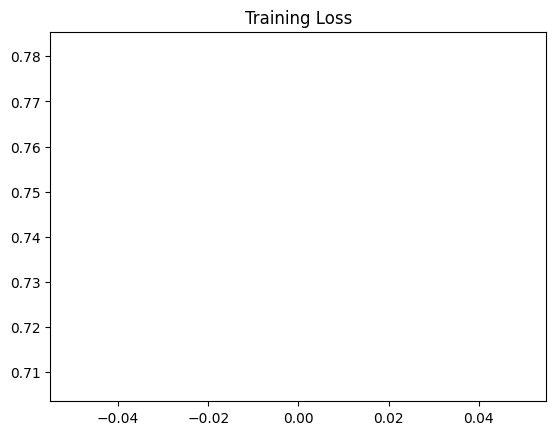

In [26]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

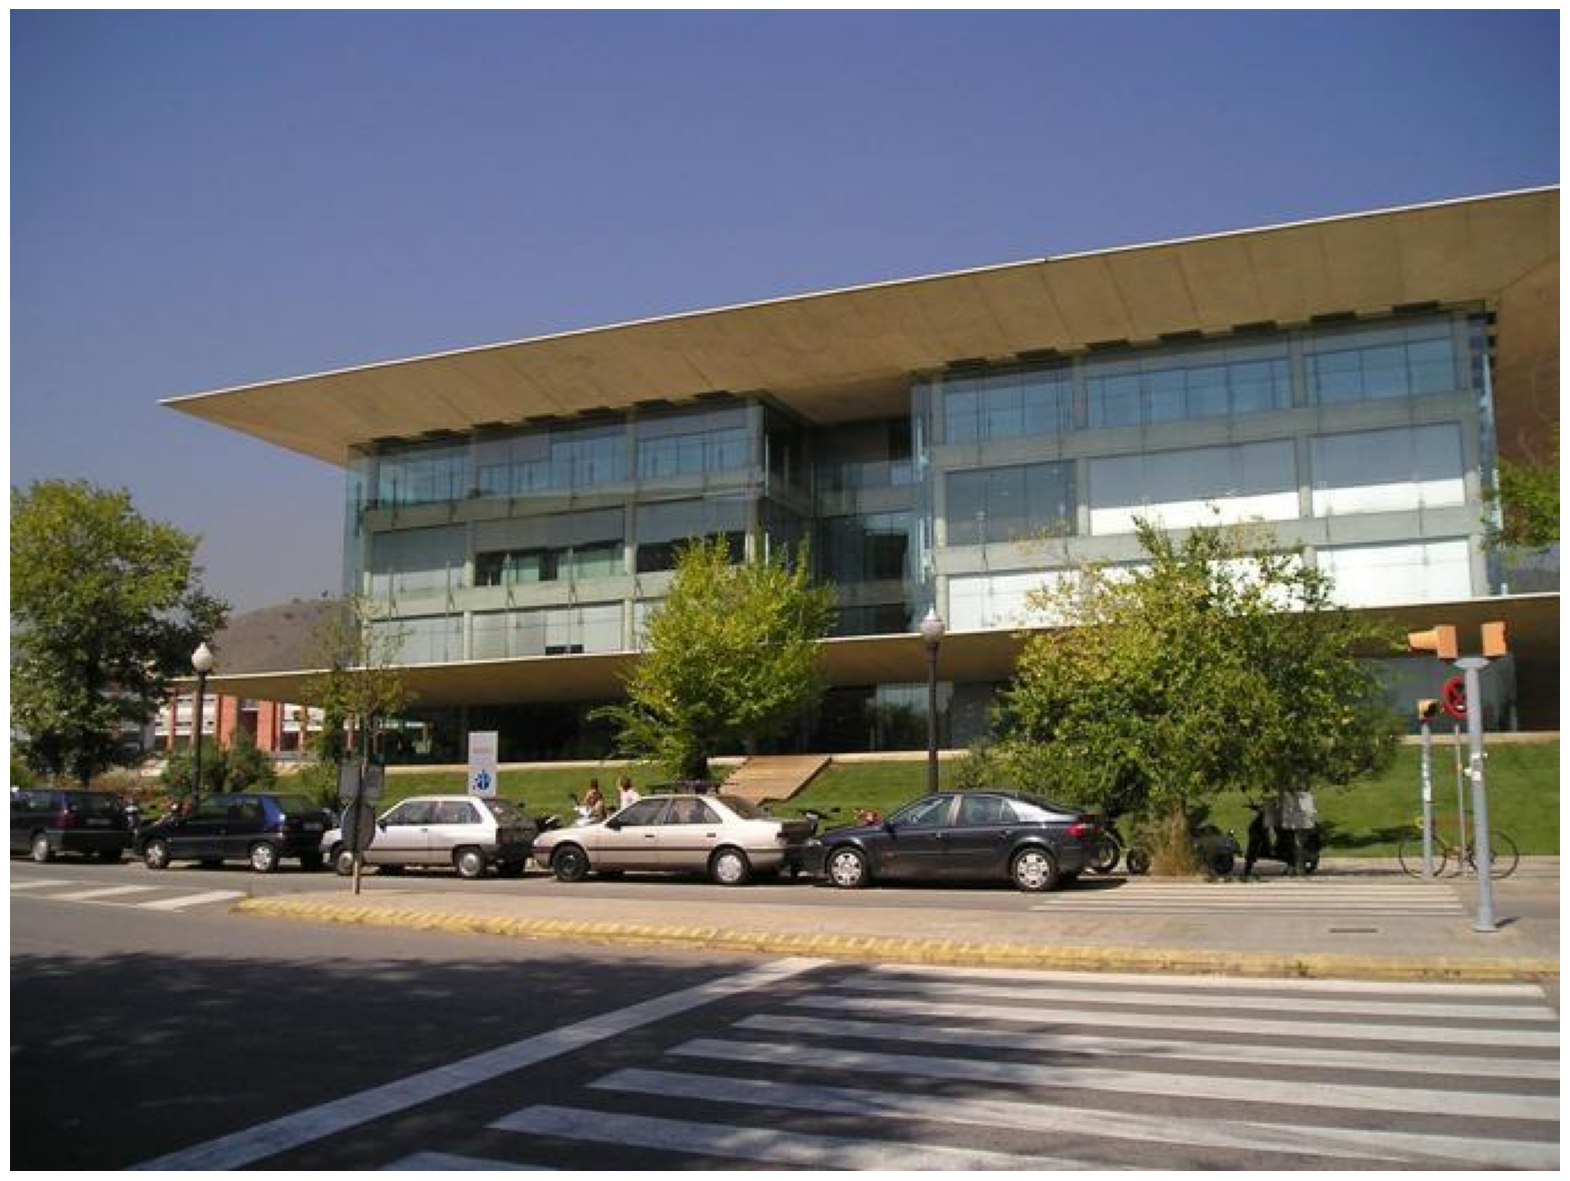

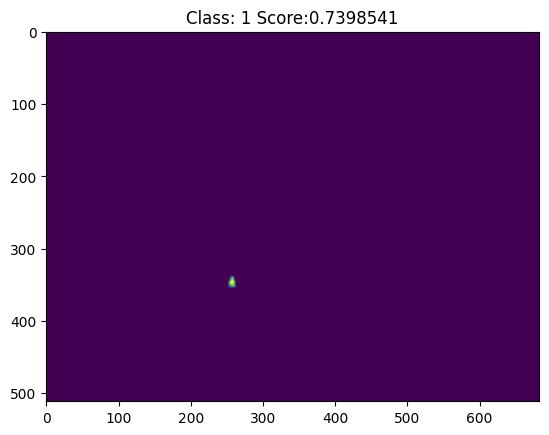

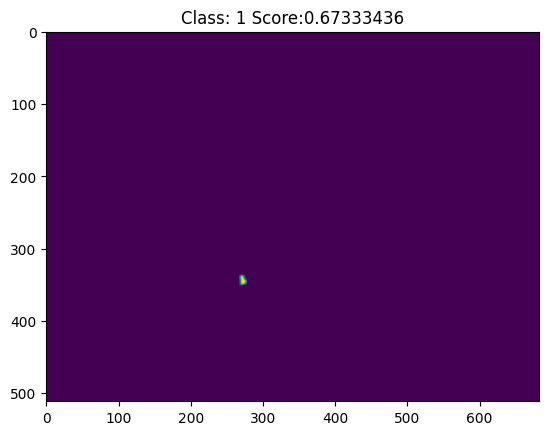

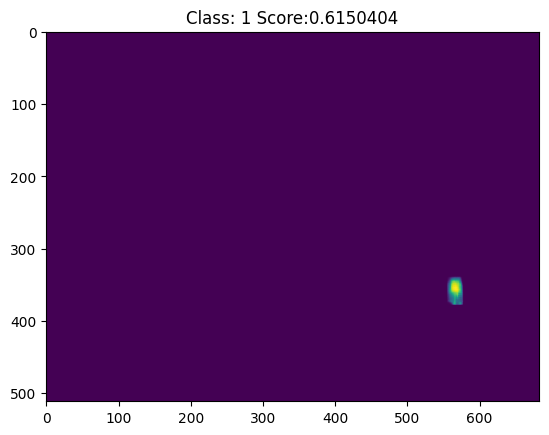

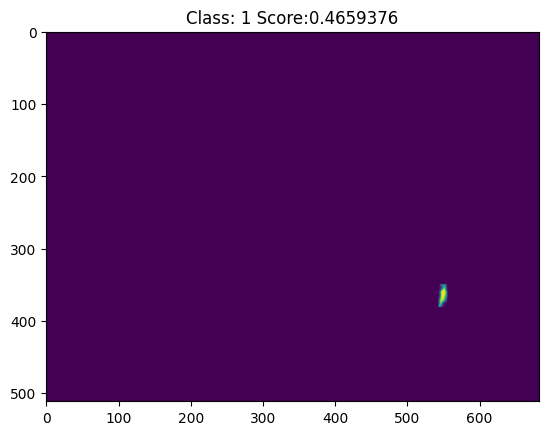

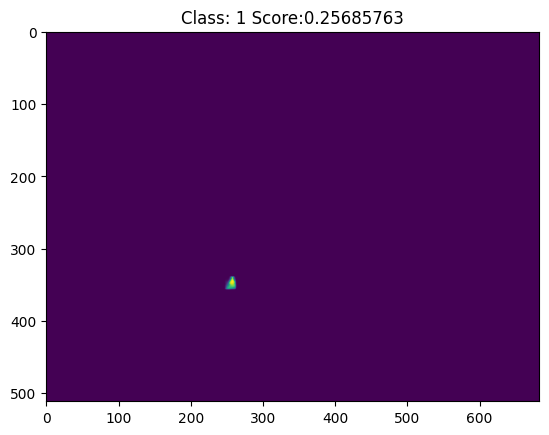

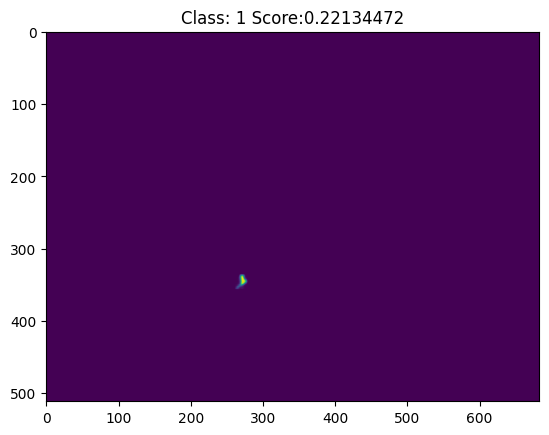

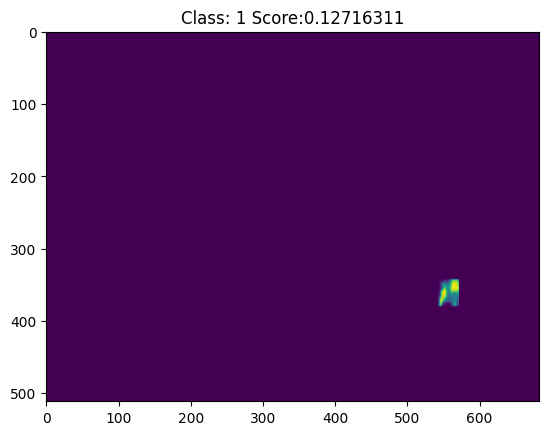

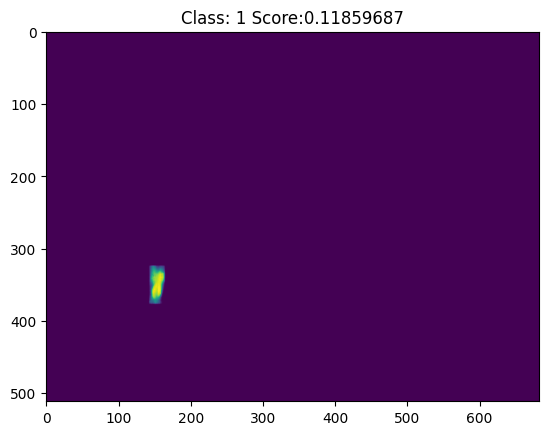

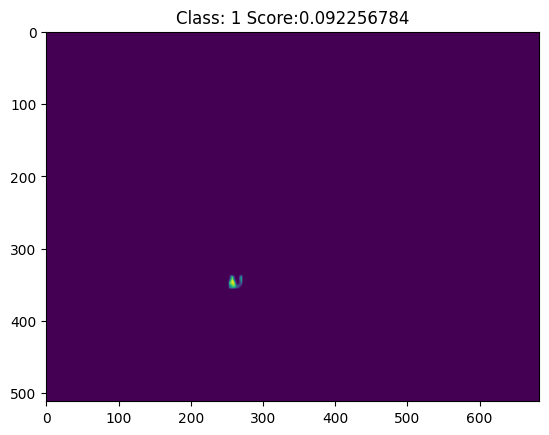

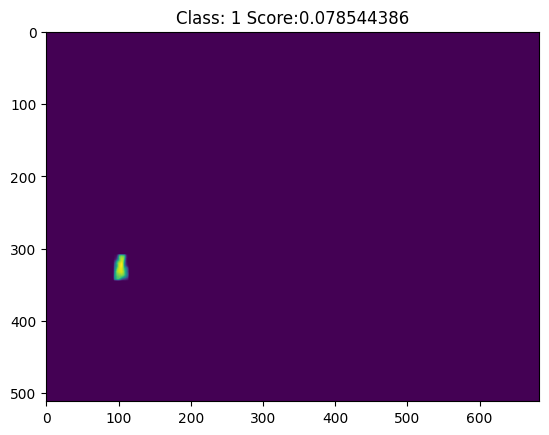

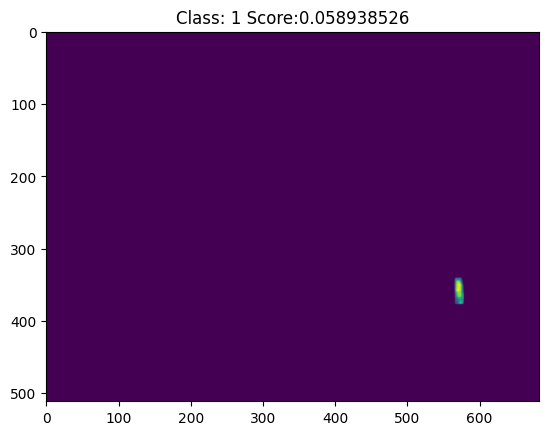

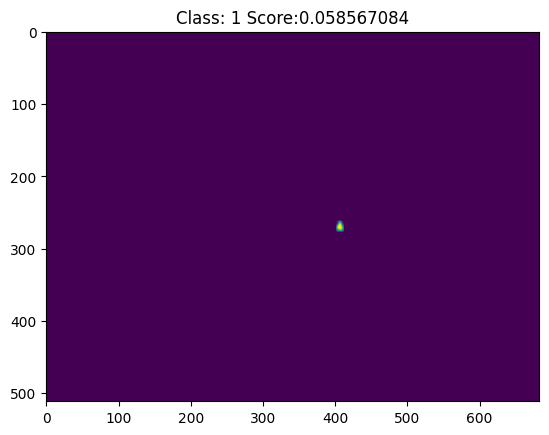

In [27]:
model.eval()
im = dataset_test[10][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

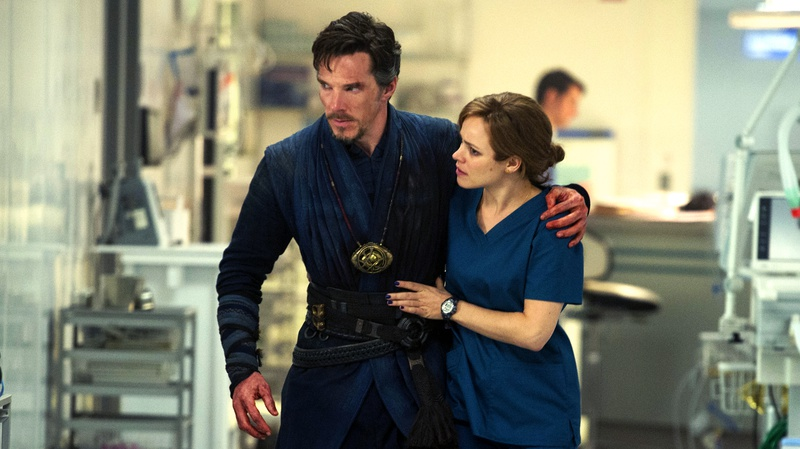

In [28]:
img = Image.open('/content/doctorspalmer.jpg').convert("RGB")
from torchvision import transforms
pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)
Image.fromarray(pil_to_tensor[0].mul(255).permute(1, 2, 0).byte().numpy())

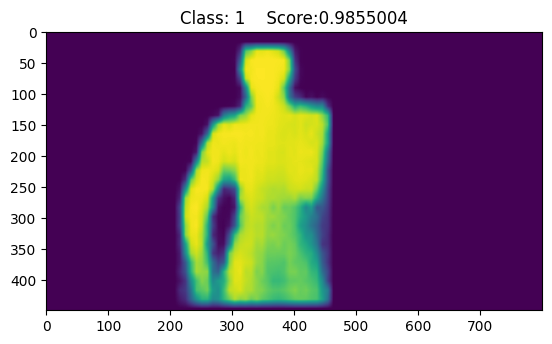

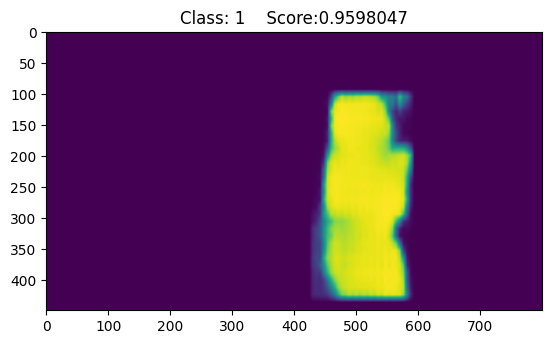

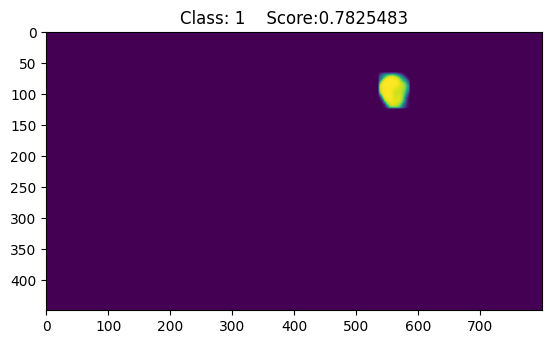

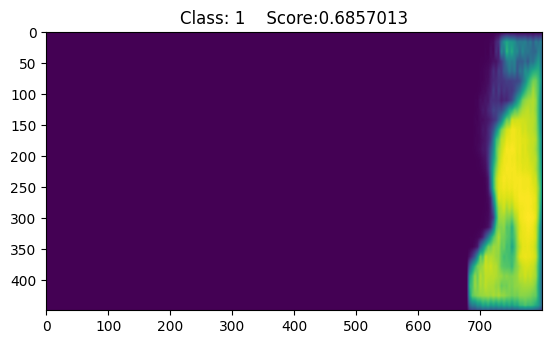

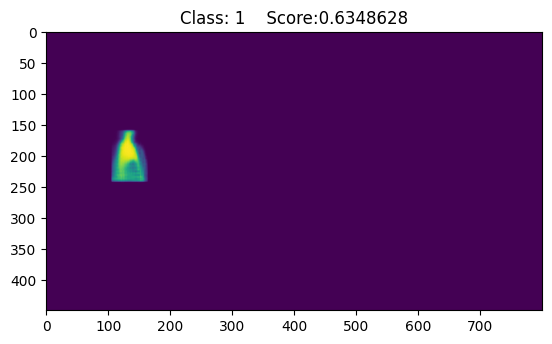

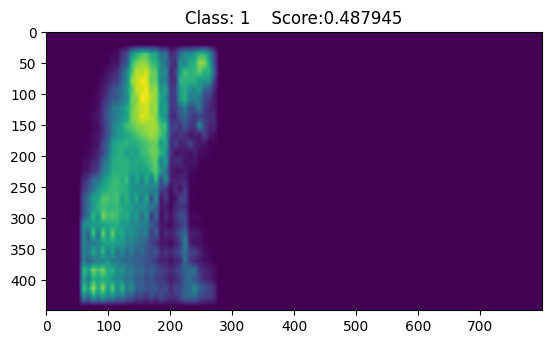

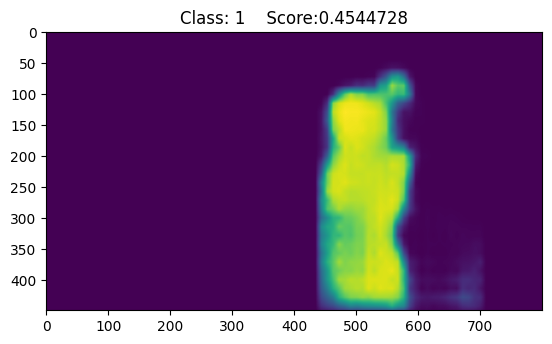

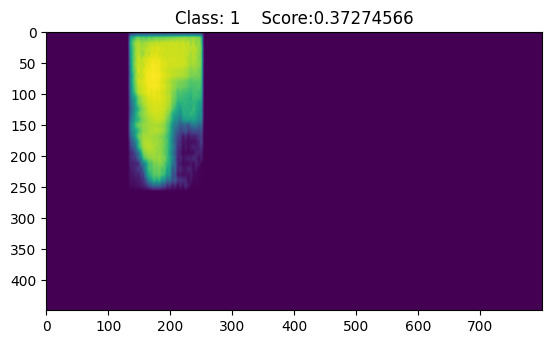

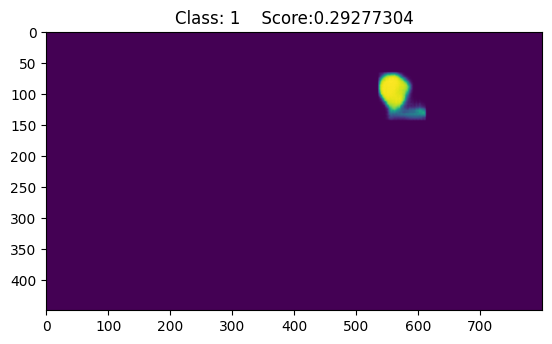

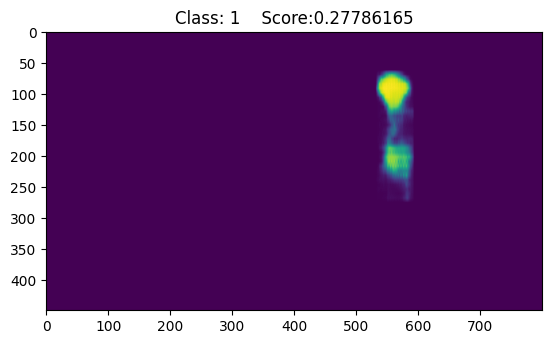

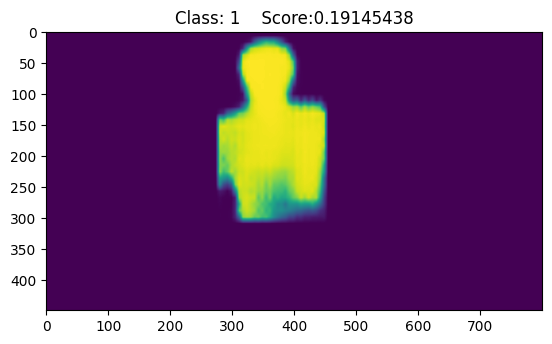

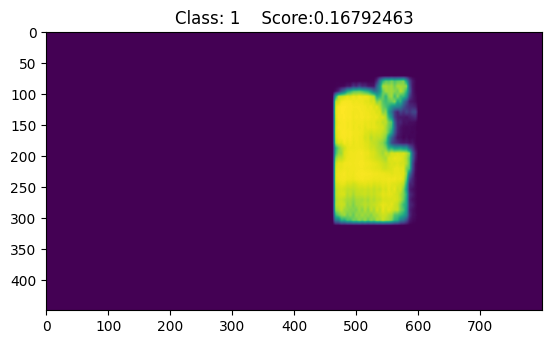

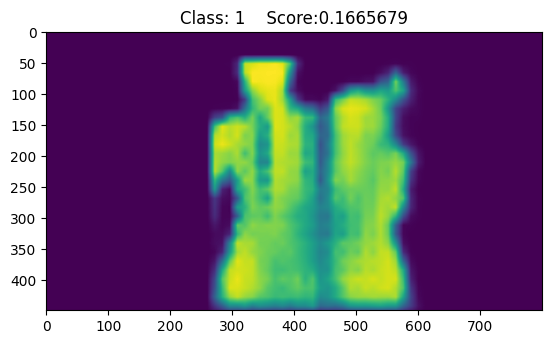

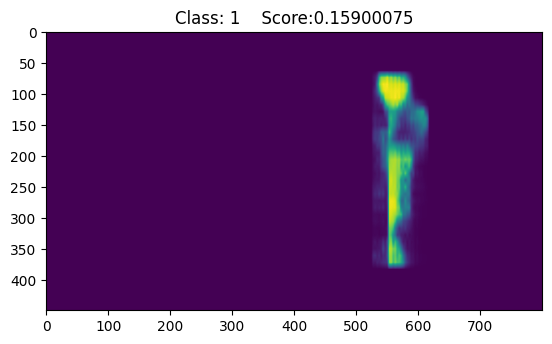

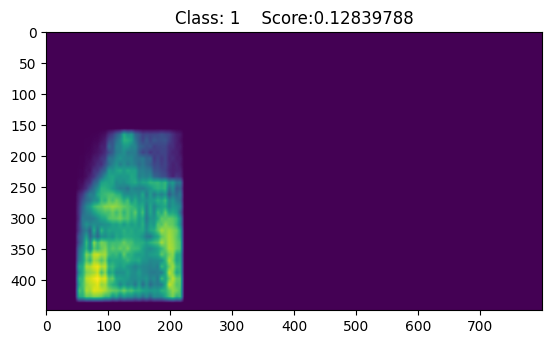

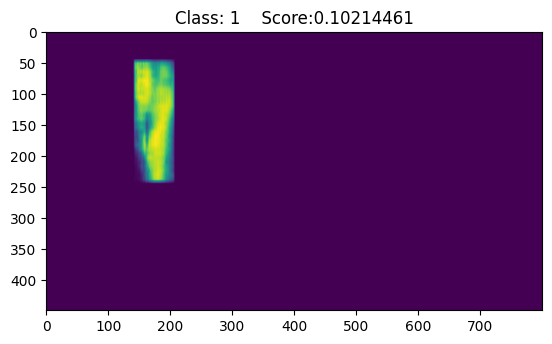

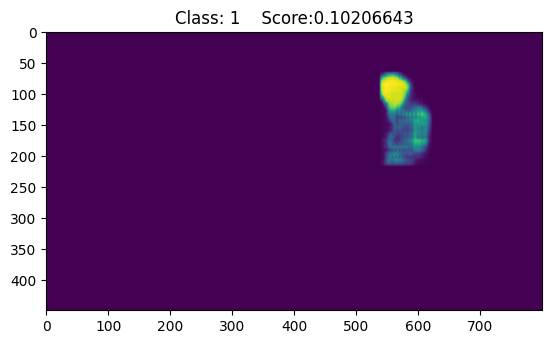

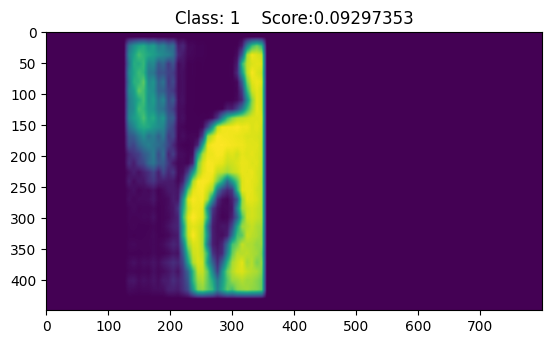

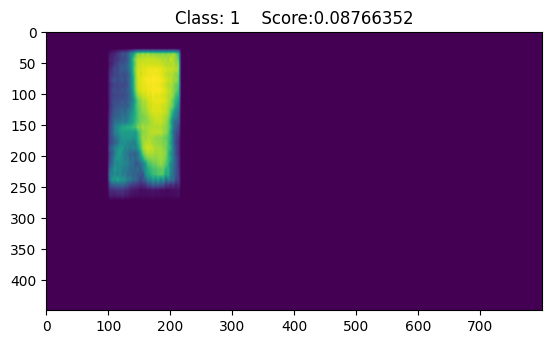

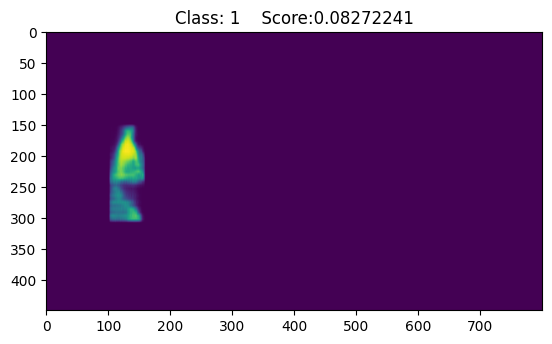

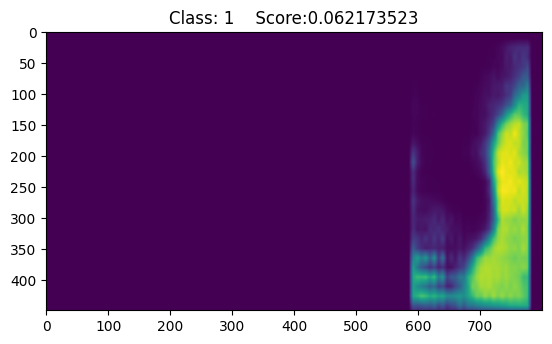

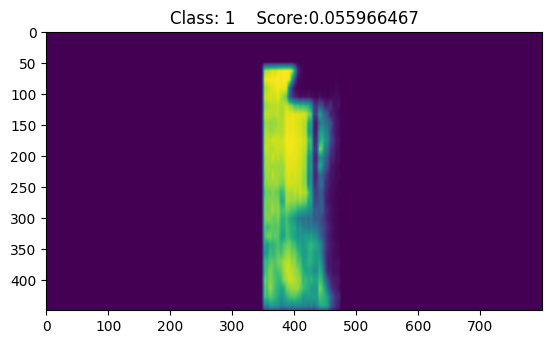

In [29]:
model.eval()
with torch.no_grad():
  prediction = model([pil_to_tensor[0].to(device)])
  for i in range(len(prediction[0]['masks'])):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
    plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+'\
    Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
    plt.show()

---